In [49]:
! pip install -q 'gwosc==0.5.4'
! pip install pycbc


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


Part 1.

In [2]:
#Loading the data.

import gwosc
import warnings
from gwpy.timeseries import TimeSeries

warnings.filterwarnings('ignore')

data = TimeSeries.read('challenge2.gwf', channel="H1:CHALLENGE2")

4096.0 Hz


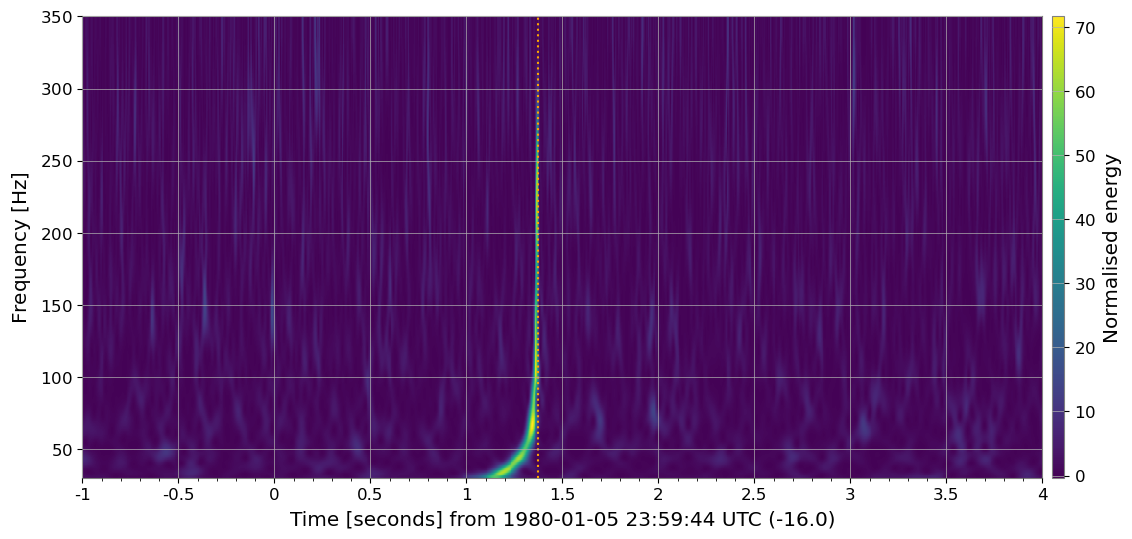

Approximate time of merger: 1980-01-05 23:59:43.75 (UTC)


In [3]:
#Plotting a q-plot of the data to try and identify the time of the merger. 

import numpy
import matplotlib.pyplot as plt

print(data.sample_rate)  # Checking the sample rate of the data.

q = data.q_transform(frange=(30,350), qrange=(10,15), outseg=(-17,-12))
qplot = q.plot()
ax = qplot.gca()
ax.colorbar(label="Normalised energy")
plt.axvline(x=-14.625, color='orange', linestyle=':')   # Draws a vertical line at the time of the signal.
plt.show()
print("Approximate time of merger: 1980-01-05 23:59:43.75 (UTC)")

Part 2.

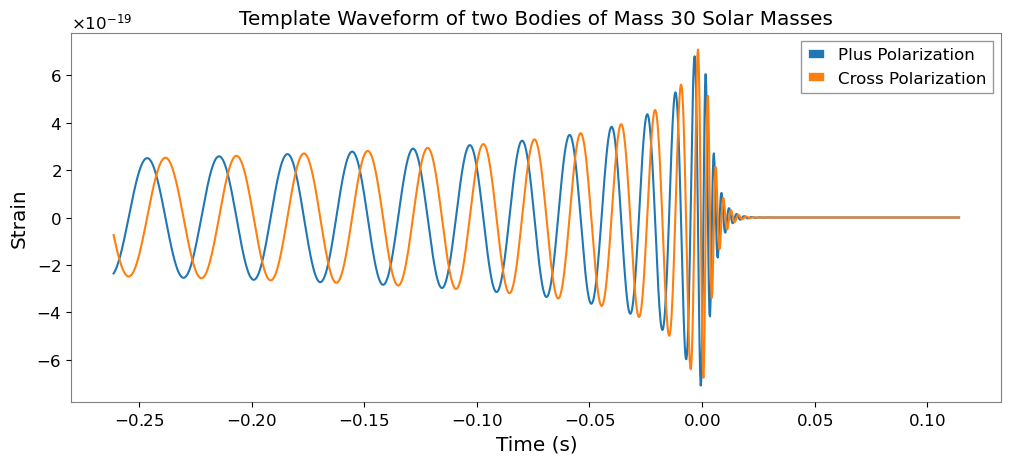

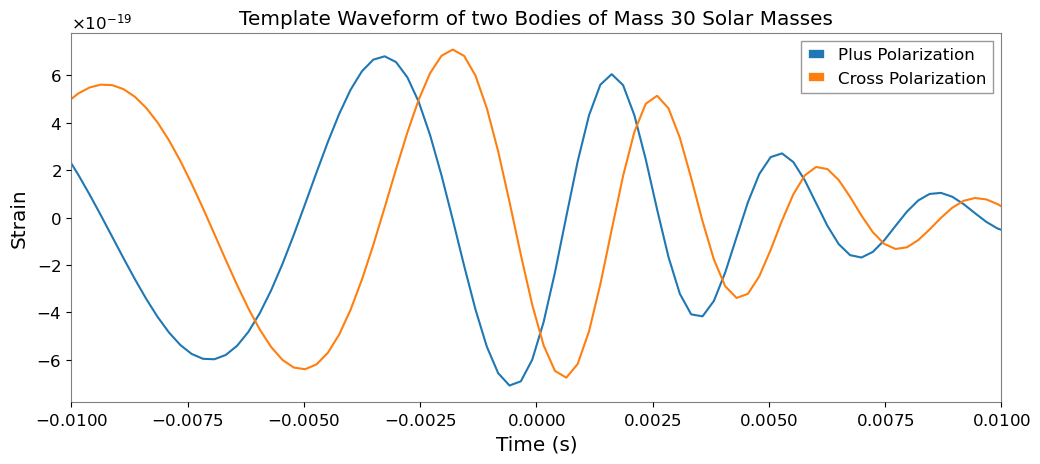

In [25]:
# Generating a time-domain template waveform for two bodies of mass 30 solar masses.

%matplotlib inline

from pycbc.waveform import get_td_waveform
import pylab

hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=30,
                         mass2=30,
                         delta_t=1.0/4096,
                         f_lower=30)

# Plotting the waveform. 

pylab.figure(figsize=pylab.figaspect(0.4))
pylab.plot(hp.sample_times, hp, label='Plus Polarization')
pylab.plot(hp.sample_times, hc, label='Cross Polarization')
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.title("Template Waveform of two Bodies of Mass 30 Solar Masses")
pylab.legend()
pylab.grid()
pylab.show()

# Zooming in near the merger time

pylab.figure(figsize=pylab.figaspect(0.4))
pylab.plot(hp.sample_times, hp, label='Plus Polarization')
pylab.plot(hp.sample_times, hc, label='Cross Polarization')
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.xlim(-.01, .01)
pylab.title("Template Waveform of two Bodies of Mass 30 Solar Masses")
pylab.legend()
pylab.grid()
pylab.show()

Part 3.

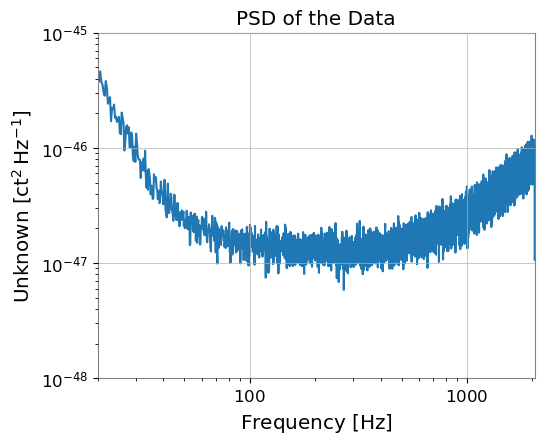

In [26]:
# Calculating and plotting the Power Spectral Density (PSD) of the data.
# Plotted on a log log scale. 

psd = data.psd(fftlength=4, method="median")  # Median because we want the average
plot = psd.plot(yscale='log', xscale='log')   # Log log scale
plt.xlim(20, 2048);       #Plotting from 20 Hz to the Nyquist Frequency
plt.ylim(1e-48,1e-45); 
plt.title("PSD of the Data")
plt.show()

Part 4. and 5.

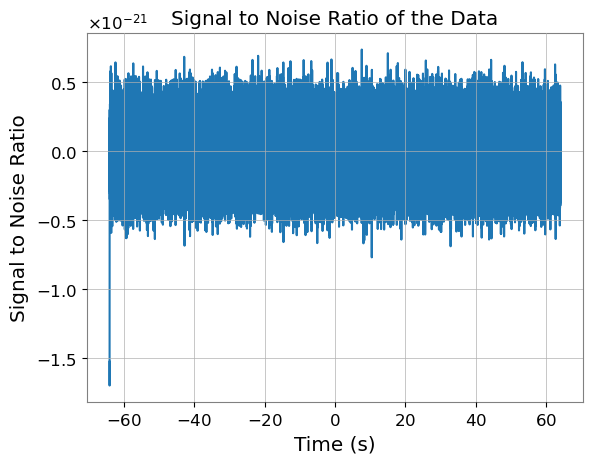

In [15]:
#Calculating the SNR time series.

%matplotlib inline

import pylab
from pycbc import frame
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass
 
# Get the data from the Hanford detector
strain = frame.read_frame('challenge2.gwf', 'H1:CHALLENGE2')

# Remove the low frequency content and downsample the data to 2048Hz
strain = highpass(strain, 15.0)
strain = resample_to_delta_t(strain, 1.0/2048)

pylab.plot(strain.sample_times, strain)
pylab.xlabel('Time (s)')
pylab.ylabel("Signal to Noise Ratio")
pylab.title("Signal to Noise Ratio of the Data")
pylab.show()

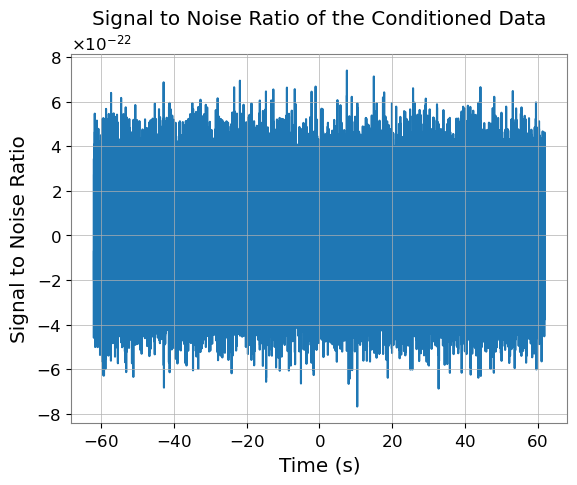

In [27]:
#Conditioning the data and replotting the conditioned data.

conditioned = strain.crop(2, 2)

pylab.plot(conditioned.sample_times, conditioned)
pylab.xlabel('Time (s)')
pylab.ylabel("Signal to Noise Ratio")
pylab.title("Signal to Noise Ratio of the Conditioned Data")
pylab.show()

In [36]:
# Conditioning the PSD and making it a frequency series to allow for an SNR to be found. 

from pycbc.psd import interpolate, inverse_spectrum_truncation

psd = conditioned.psd(4)

psd = interpolate(psd, conditioned.delta_f)

psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                  low_frequency_cutoff=15)

In [37]:
#Resizing the vector to match our conditioned data

from pycbc.waveform import get_td_waveform

m = 30 # Solar masses
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t,
                     f_lower=20)

hp.resize(len(conditioned))

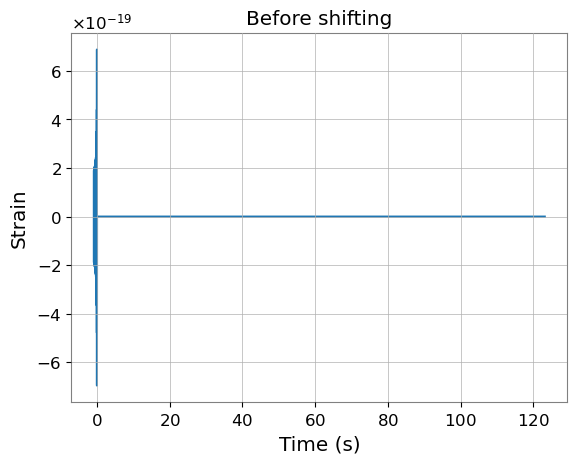

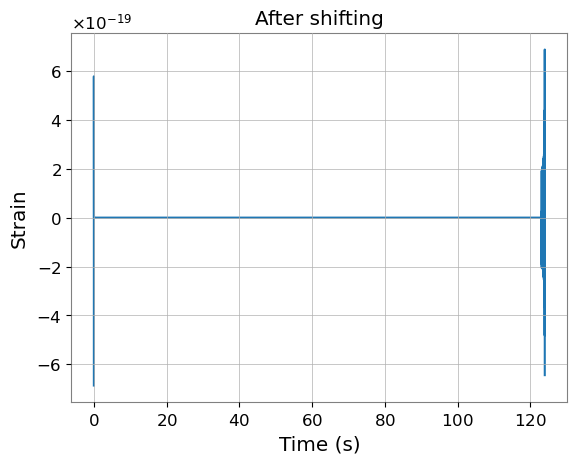

In [38]:
# Plotting the signal before and after shifting

pylab.figure()
pylab.title('Before shifting')
pylab.plot(hp.sample_times, hp)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.show()

template = hp.cyclic_time_shift(hp.start_time)

pylab.figure()
pylab.title('After shifting')
pylab.plot(template.sample_times, template)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.show()

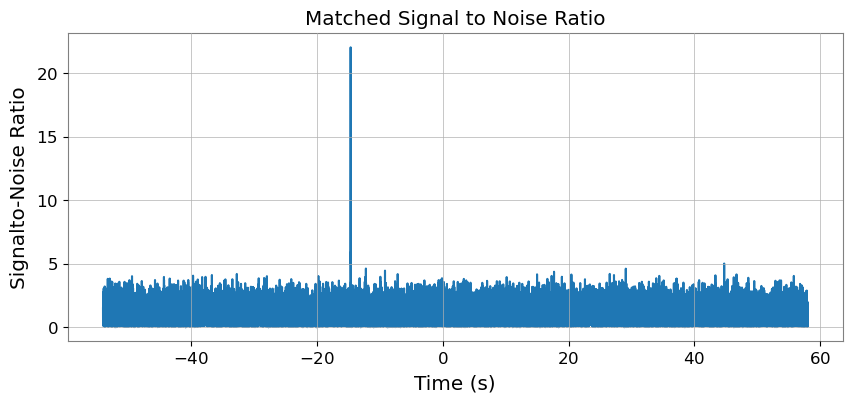

We found a signal at -14.6328125s with SNR 22.054545591712564


In [39]:
from pycbc.filter import matched_filter
import numpy

snr = matched_filter(template, conditioned,
                     psd=psd, low_frequency_cutoff=20)

snr = snr.crop(4 + 4, 4)

pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signalto-Noise Ratio')
pylab.xlabel('Time (s)')
pylab.title("Matched Signal to Noise Ratio")

pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time,abs(snrp)))

The matched filter SNR of the signal is 22.054545591712564.

All calculation and coding techniques were adapted from the GW_BigData_tutorial-2 found in the module section of the PRA3024 Canvas page.

This tutorial can be found at: https://canvas.maastrichtuniversity.nl/courses/17323/files/3534550/download?download_frd=1